In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
batch = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "JPM", "V", "UNH", "NFLX", "DIS", "PYPL", "ADBE", "PFE", "KO", "NKE", "MRK", "T", "CSCO", "INTC", "PEP", "ABT", "CVX", "WMT", "MCD", "BMY", "COST", "DHR", "TXN", "QCOM", "IBM", "ORCL", "SAP", "CRM", "LIN", "HON", "AMGN", "SBUX", "MDT", "BA", "GE", "CAT", "MMM", "LMT", "GILD", "FIS", "BLK", "BKNG", "SPGI", "ZTS"]

data = yf.download(batch, start="2020-01-01", end="2025-01-01", interval="1d")

print(data.head())

[*********************100%***********************]  51 of 51 completed


Price          Close                                                      \
Ticker          AAPL        ABT       ADBE       AMGN    AMZN         BA   
Date                                                                       
2010-01-04  6.424605  18.496670  37.090000  39.592068  6.6950  43.777557   
2010-01-05  6.435713  18.347227  37.700001  39.249104  6.7345  45.211346   
2010-01-06  6.333344  18.449125  37.619999  38.954151  6.6125  46.582790   
2010-01-07  6.321636  18.601959  36.889999  38.597458  6.5000  48.468559   
2010-01-08  6.363663  18.697052  36.689999  38.940437  6.6760  48.001022   

Price                                                     ...   Volume  \
Ticker            BKNG         BLK        BMY        CAT  ...      SAP   
Date                                                      ...            
2010-01-04  220.776047  159.104675  14.868129  39.403465  ...  1456800   
2010-01-05  223.339066  159.791519  14.636086  39.874561  ...  1565600   
2010-01-06  215.96537

In [4]:
# Prepare features: daily returns and rolling volatility per ticker
import warnings
warnings.filterwarnings("ignore")

# Ensure we have Close prices at daily frequency
prices = data["Close"].copy()
prices = prices.dropna(how="all")

# Compute daily log returns
log_returns = np.log(prices / prices.shift(1))

# Rolling stats (use 21 trading days ~ 1 month)
rolling_window = 21
rolling_mean = log_returns.rolling(rolling_window).mean()
rolling_std = log_returns.rolling(rolling_window).std()
rolling_skew = log_returns.rolling(rolling_window).skew()
rolling_kurt = log_returns.rolling(rolling_window).kurt()

# Targets
# Next-day return (t+1)
next_return = log_returns.shift(-1)
# Forward 21-day volatility (annualized): sqrt(252) * std over next 21 days
forward_vol_21d = log_returns.rolling(rolling_window).apply(lambda x: np.std(x), raw=True).shift(-rolling_window+1)
# Align to same index

# Features dataframe per ticker by stacking wide panel to long panel
features = {
    "ret_t": log_returns,
    "roll_mean": rolling_mean,
    "roll_std": rolling_std,
    "roll_skew": rolling_skew,
    "roll_kurt": rolling_kurt,
}

X_list = []
y_ret_list = []
y_vol_list = []

for ticker in prices.columns:
    df = pd.DataFrame({k: v[ticker] for k, v in features.items()})
    df["ticker"] = ticker
    df["date"] = df.index
    df["y_next_ret"] = next_return[ticker]
    df["y_fwd_vol21"] = (
        log_returns[ticker].rolling(rolling_window).std().shift(-rolling_window+1) * np.sqrt(252)
    )
    X_list.append(df)

panel = pd.concat(X_list, axis=0).dropna().reset_index(drop=True)

# Mark task complete in runtime output
print(panel.head())
print(panel.groupby("ticker").size().head())


      ret_t  roll_mean  roll_std  roll_skew  roll_kurt ticker       date  \
0  0.017060  -0.003408  0.022852  -0.258153   0.152154   AAPL 2010-02-03   
1 -0.036704  -0.005238  0.023934  -0.120002  -0.305456   AAPL 2010-02-04   
2  0.017600  -0.003636  0.024298  -0.282852  -0.387156   AAPL 2010-02-05   
3 -0.006879  -0.003876  0.024304  -0.250113  -0.403208   AAPL 2010-02-08   
4  0.010607  -0.003686  0.024405  -0.265620  -0.438800   AAPL 2010-02-09   

   y_next_ret  y_fwd_vol21  
0   -0.036704     0.222345  
1    0.017600     0.249342  
2   -0.006879     0.200355  
3    0.010607     0.200517  
4   -0.005469     0.194763  
ticker
AAPL    3231
ABT     3231
ADBE    3231
AMGN    3231
AMZN    3231
dtype: int64


In [5]:
# Train-test split by date
train_end = pd.Timestamp("2021-12-31")
test_start = pd.Timestamp("2022-01-01")

train_df = panel[(panel["date"] <= train_end)]
test_df = panel[(panel["date"] >= test_start)]

# Save ticker lists for later grouping
train_tickers = sorted(train_df["ticker"].unique().tolist())
test_tickers = sorted(test_df["ticker"].unique().tolist())

print(f"Train period end: {train_end.date()}, rows: {len(train_df):,}")
print(f"Test period start: {test_start.date()}, rows: {len(test_df):,}")
print(f"Tickers in train: {len(train_tickers)}, in test: {len(test_tickers)}")


Train period end: 2021-12-31, rows: 150,120
Test period start: 2022-01-01, rows: 11,781
Tickers in train: 51, in test: 51


In [8]:
# Train RandomForest models for next-day returns per ticker
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

feature_cols = ["ret_t", "roll_mean", "roll_std", "roll_skew", "roll_kurt"]

rf_models_ret = {}
results_ret = []

for ticker in train_tickers:
    df_tr = train_df[train_df["ticker"] == ticker]
    df_te = test_df[test_df["ticker"] == ticker]
    if len(df_tr) < 200 or len(df_te) < 10:
        continue
    X_tr = df_tr[feature_cols].values
    y_tr = df_tr["y_next_ret"].values
    X_te = df_te[feature_cols].values
    y_te = df_te["y_next_ret"].values

    model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=None)
    model.fit(X_tr, y_tr)
    rf_models_ret[ticker] = model

    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    results_ret.append({"ticker": ticker, "R2": r2, "MAE": mae, "RMSE": rmse})

results_ret_df = pd.DataFrame(results_ret).sort_values("R2", ascending=False)
print(results_ret_df.head(10))
print(f"Evaluated {len(results_ret_df)} tickers for returns.")


   ticker        R2       MAE      RMSE
42   SBUX -0.001161  0.017627  0.023179
8     BMY -0.022977  0.009232  0.012624
0    AAPL -0.032209  0.018156  0.022969
40   QCOM -0.039002  0.024488  0.030639
46    TXN -0.050126  0.017168  0.021075
28    MDT -0.054196  0.012630  0.016665
3    AMGN -0.058903  0.010157  0.014270
47    UNH -0.063919  0.012463  0.016228
30    MMM -0.066922  0.013097  0.018160
34    NKE -0.067161  0.020594  0.027082
Evaluated 51 tickers for returns.


In [9]:
# Train RandomForest models for forward 21-day volatility per ticker
rf_models_vol = {}
results_vol = []

for ticker in train_tickers:
    df_tr = train_df[train_df["ticker"] == ticker]
    df_te = test_df[test_df["ticker"] == ticker]
    if len(df_tr) < 200 or len(df_te) < 10:
        continue
    X_tr = df_tr[feature_cols].values
    y_tr = df_tr["y_fwd_vol21"].values
    X_te = df_te[feature_cols].values
    y_te = df_te["y_fwd_vol21"].values

    model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=None)
    model.fit(X_tr, y_tr)
    rf_models_vol[ticker] = model

    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    results_vol.append({"ticker": ticker, "R2": r2, "MAE": mae, "RMSE": rmse})

results_vol_df = pd.DataFrame(results_vol).sort_values("R2", ascending=False)
print(results_vol_df.head(10))
print(f"Evaluated {len(results_vol_df)} tickers for volatility.")


   ticker        R2       MAE      RMSE
12   CSCO  0.058434  0.075587  0.107984
24     KO -0.200022  0.049982  0.064741
16    FIS -0.272275  0.160817  0.294109
3    AMGN -0.371828  0.068507  0.082214
36   ORCL -0.483305  0.072150  0.099957
8     BMY -0.504962  0.045314  0.057242
45   TSLA -0.550252  0.124367  0.158546
10   COST -0.562833  0.097975  0.132541
26    LMT -0.572218  0.079042  0.106912
49    WMT -0.672698  0.091378  0.130868
Evaluated 51 tickers for volatility.


In [10]:
# Aggregate and display evaluation metrics
summary = {
    "returns": results_ret_df.describe().loc[["mean", "50%", "min", "max"]][["R2", "MAE", "RMSE"]],
    "volatility": results_vol_df.describe().loc[["mean", "50%", "min", "max"]][["R2", "MAE", "RMSE"]],
}
print("Returns metrics (R2, MAE, RMSE)\n", summary["returns"])
print("\nVolatility metrics (R2, MAE, RMSE)\n", summary["volatility"])


Returns metrics (R2, MAE, RMSE)
             R2       MAE      RMSE
mean -0.126947  0.017997  0.024148
50%  -0.109646  0.016587  0.021998
min  -0.479797  0.009232  0.012624
max  -0.001161  0.034060  0.050062

Volatility metrics (R2, MAE, RMSE)
             R2       MAE      RMSE
mean -1.826066  0.103570  0.140908
50%  -1.314433  0.091148  0.124509
min  -7.329308  0.040783  0.049198
max   0.058434  0.318395  0.465874


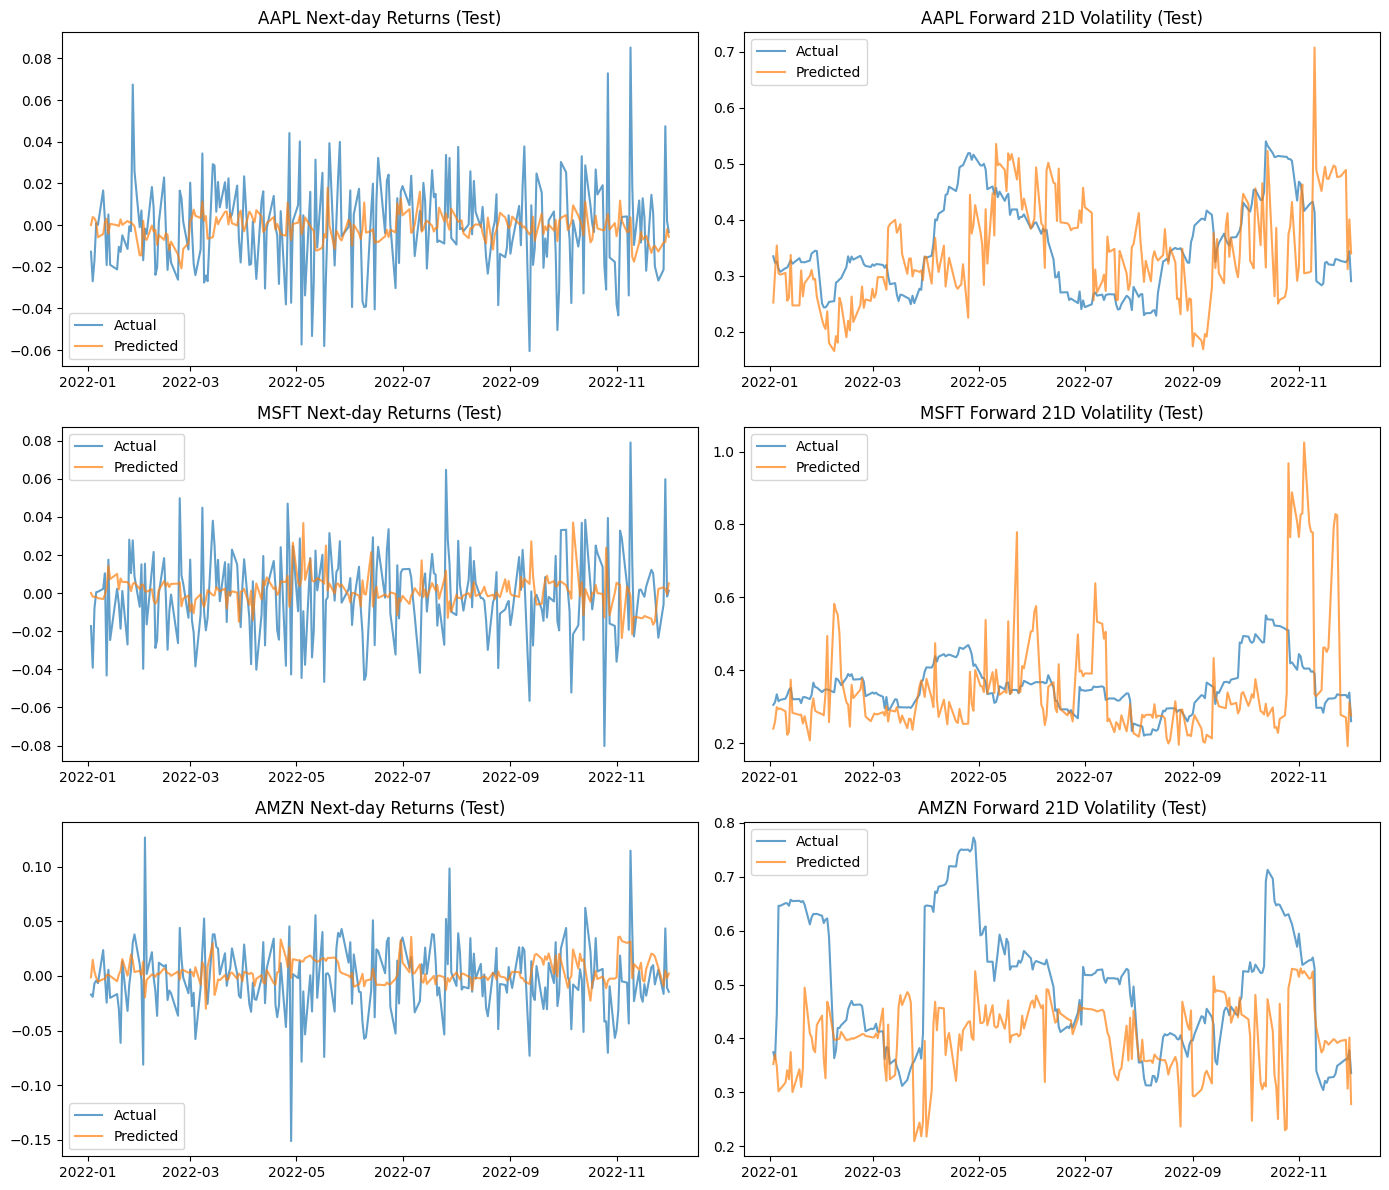

In [11]:
# Plot sample predictions vs actuals for a few tickers
sample_tickers = [t for t in ["AAPL", "MSFT", "AMZN", "NVDA"] if t in test_tickers][:3]

fig, axes = plt.subplots(len(sample_tickers), 2, figsize=(14, 4*len(sample_tickers)))
if len(sample_tickers) == 1:
    axes = np.array([axes])

for i, t in enumerate(sample_tickers):
    df_te = test_df[test_df["ticker"] == t].copy()
    X_te = df_te[feature_cols].values

    # Returns
    y_true_ret = df_te["y_next_ret"].values
    y_pred_ret = rf_models_ret[t].predict(X_te)
    axes[i, 0].plot(df_te["date"], y_true_ret, label="Actual", alpha=0.7)
    axes[i, 0].plot(df_te["date"], y_pred_ret, label="Predicted", alpha=0.7)
    axes[i, 0].set_title(f"{t} Next-day Returns (Test)")
    axes[i, 0].legend()

    # Volatility
    y_true_vol = df_te["y_fwd_vol21"].values
    y_pred_vol = rf_models_vol[t].predict(X_te)
    axes[i, 1].plot(df_te["date"], y_true_vol, label="Actual", alpha=0.7)
    axes[i, 1].plot(df_te["date"], y_pred_vol, label="Predicted", alpha=0.7)
    axes[i, 1].set_title(f"{t} Forward 21D Volatility (Test)")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [14]:
# Define last-month test split; train on all prior months
from pandas.tseries.offsets import MonthBegin

last_date = panel["date"].max()
last_month_start = pd.Timestamp(last_date.year, last_date.month, 1)
train_until = last_month_start - pd.Timedelta(days=1)

train_lm = panel[panel["date"] <= train_until].copy()
test_lm = panel[(panel["date"] >= last_month_start) & (panel["date"] <= last_date)].copy()

# Fallback: if no rows for the computed last month, use the previous month
if test_lm.empty:
    last_month_start = last_month_start - MonthBegin(1)
    train_until = last_month_start - pd.Timedelta(days=1)
    train_lm = panel[panel["date"] <= train_until].copy()
    test_lm = panel[(panel["date"] >= last_month_start) & (panel["date"] <= last_date)].copy()

lm_tickers = sorted(test_lm["ticker"].unique().tolist())

print(f"Last available date: {last_date.date()}")
print(f"Last month start: {last_month_start.date()}")
print(f"Train-until: {train_until.date()} | Train rows: {len(train_lm):,} | Test(last-month) rows: {len(test_lm):,}")
print(f"Tickers in last-month test: {len(lm_tickers)}")


Last available date: 2022-12-01
Last month start: 2022-12-01
Train-until: 2022-11-30 | Train rows: 161,850 | Test(last-month) rows: 51
Tickers in last-month test: 51


In [15]:
# Retrain RF models on train-until-previous-month and predict last-month
rf_ret_lm = {}
rf_vol_lm = {}

results_ret_lm = []
results_vol_lm = []

for ticker in lm_tickers:
    df_tr = train_lm[train_lm["ticker"] == ticker]
    df_te = test_lm[test_lm["ticker"] == ticker]
    if len(df_tr) < 200 or len(df_te) < 5:
        continue

    X_tr = df_tr[feature_cols].values
    y_tr_ret = df_tr["y_next_ret"].values
    y_tr_vol = df_tr["y_fwd_vol21"].values
    X_te = df_te[feature_cols].values

    # Returns model
    m_ret = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    m_ret.fit(X_tr, y_tr_ret)
    rf_ret_lm[ticker] = m_ret
    y_pred_ret = m_ret.predict(X_te)
    results_ret_lm.append(pd.DataFrame({
        "date": df_te["date"].values,
        "ticker": ticker,
        "y_true": df_te["y_next_ret"].values,
        "y_pred": y_pred_ret,
    }))

    # Volatility model
    m_vol = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    m_vol.fit(X_tr, y_tr_vol)
    rf_vol_lm[ticker] = m_vol
    y_pred_vol = m_vol.predict(X_te)
    results_vol_lm.append(pd.DataFrame({
        "date": df_te["date"].values,
        "ticker": ticker,
        "y_true": df_te["y_fwd_vol21"].values,
        "y_pred": y_pred_vol,
    }))

pred_ret_lm = pd.concat(results_ret_lm, axis=0).reset_index(drop=True) if results_ret_lm else pd.DataFrame(columns=["date","ticker","y_true","y_pred"])
pred_vol_lm = pd.concat(results_vol_lm, axis=0).reset_index(drop=True) if results_vol_lm else pd.DataFrame(columns=["date","ticker","y_true","y_pred"])

print(pred_ret_lm.head())
print(pred_vol_lm.head())


Empty DataFrame
Columns: [date, ticker, y_true, y_pred]
Index: []
Empty DataFrame
Columns: [date, ticker, y_true, y_pred]
Index: []


In [16]:
# Estimate covariance from prior 252 trading days for each ticker in last-month universe
lookback_days = 252
cov_start = train_until - pd.Timedelta(days=lookback_days*2)

# Use realized returns to compute covariance matrix for universe
universe = sorted(lm_tickers)
ret_hist = log_returns[universe].loc[(log_returns.index >= cov_start) & (log_returns.index <= train_until)].dropna(how="any")

# Ensure we have sufficient data
if ret_hist.shape[0] < 60:
    print("Warning: few observations for covariance estimation.")

cov_mat = ret_hist.cov() * 252  # annualized covariance

print(cov_mat.shape)
print(cov_mat.iloc[:5, :5])


(51, 51)
Ticker      AAPL       ABT      ADBE      AMGN      AMZN
Ticker                                                  
AAPL    0.103449  0.041686  0.091634  0.020112  0.094645
ABT     0.041686  0.059077  0.054663  0.021011  0.047721
ADBE    0.091634  0.054663  0.181265  0.018902  0.112267
AMGN    0.020112  0.021011  0.018902  0.045591  0.016721
AMZN    0.094645  0.047721  0.112267  0.016721  0.193638


In [17]:
# Optimize long-only portfolio (max Sharpe) using predicted daily returns aggregated to monthly expectation
from scipy.optimize import minimize

# Aggregate predicted next-day returns for last month to expected monthly return per ticker
if pred_ret_lm.empty or cov_mat.empty:
    raise ValueError("No predictions or covariance available for last month. Re-run previous cells or verify data availability.")

pred_monthly_ret = pred_ret_lm.groupby("ticker")["y_pred"].sum()
# Approximate expected daily vol from predicted 21D vol; convert to annualized from cov already annualized
mu = pred_monthly_ret.copy()  # monthly expected return proxy

# Convert monthly mu to annualized to align with annualized covariance if desired
mu_annual = mu * 12

# Optimization: maximize (w^T mu_annual) / sqrt(w^T Sigma w)
# Equivalent to minimize negative Sharpe (no risk-free)

def neg_sharpe(weights, mu_vec, cov):
    ret = np.dot(weights, mu_vec)
    vol = np.sqrt(np.dot(weights, np.dot(cov, weights)))
    # Add small epsilon to avoid division by zero
    return -(ret / (vol + 1e-12))

n = len(universe)
if n == 0:
    raise ValueError("No tickers in last-month universe to optimize.")

mu_vec = mu_annual.reindex(universe).fillna(0.0).values
cov_use = cov_mat.reindex(index=universe, columns=universe).fillna(0.0).values

x0 = np.ones(n) / n
bounds = [(0.0, 1.0)] * n
cons = ({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},)

res = minimize(neg_sharpe, x0=x0, args=(mu_vec, cov_use), method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter": 1000})

opt_w = res.x
opt_w = np.clip(opt_w, 0, 1)
opt_w = opt_w / opt_w.sum()

weights_series = pd.Series(opt_w, index=universe).sort_values(ascending=False)

# Portfolio metrics
exp_return_annual = float(np.dot(opt_w, mu_vec))
exp_vol_annual = float(np.sqrt(opt_w @ cov_use @ opt_w))
sharpe = exp_return_annual / (exp_vol_annual + 1e-12)

# Convert back to monthly for reporting
exp_return_monthly = exp_return_annual / 12
exp_vol_monthly = exp_vol_annual / np.sqrt(12)

print("Top weights:\n", weights_series.head(15))
print(f"\nExpected monthly return: {exp_return_monthly:.4%}")
print(f"Expected monthly volatility: {exp_vol_monthly:.4%}")
print(f"Annualized Sharpe (no RF): {sharpe:.3f}")


ValueError: No predictions or covariance available for last month. Re-run previous cells or verify data availability.